# Showcases integrated gradients on CIFAR10 dataset

**Downloaded from here:** https://captum.ai/tutorials/CIFAR_TorchVision_Interpret<br><br>
This tutorial demonstrates how to apply model interpretability algorithms from Captum library on a simple model and test samples from CIFAR dataset.

In this tutorial we build a simple model as described in:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

Then we use attribution algorithms such as `IntegratedGradients`, `Saliency`, `DeepLift` and `NoiseTunnel` to attribute the label of the image to the input pixels and visualize it.
  
  **Note:** Before running this tutorial, please install the torchvision, and matplotlib packages.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In the cell below we load test and train datasets, define image transformers and supported classification label classes.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


We define a classification network based on the architecture proposed in the following tutorial:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


Trains `Net` model for a very small number of epochs. The training code snippet is copied from the tutorial mentioned above. 
In order to avoid training the model every time from scratch, we save a pretrained version of the model in `models` folder and load it from there. https://github.com/pytorch/captum/blob/master/tutorials/models/cifar_torchvision.pt

In [7]:
USE_PRETRAINED_MODEL = True
DEVICE = "cuda:0"
net = net.to(DEVICE)

if USE_PRETRAINED_MODEL:
    print("Using existing trained model")
    net.load_state_dict(torch.load('../../models/cifar_torchvision.pt'))
else:
    for epoch in range(5):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), '../../models/cifar_torchvision.pt')

Using existing trained model


In the cell below we load some images from the test dataset and perform predictions.

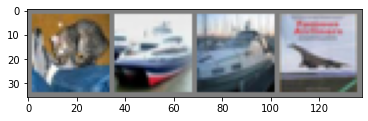

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [8]:

def imshow(img, transpose = True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = net(images.to(DEVICE))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Let's choose a test image at index `ind` and apply some of our attribution algorithms on it.

In [9]:
ind = 3

input = images[ind].unsqueeze(0).to(DEVICE)
input.requires_grad = True

Sets model to eval mode for interpretation purposes

In [10]:
net.eval()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
)

A generic function that will be used for calling `attribute` on attribution algorithm defined in input.

In [11]:
def attribute_image_features(algorithm, input, **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions
        

Computes gradients with respect to class `ind` and transposes them for visualization purposes.

In [12]:
saliency = Saliency(net)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

Applies integrated gradients attribution algorithm on test image. Integrated Gradients computes the integral of the gradients of the output prediction for the class index `ind` with respect to the input image pixels. More details about integrated gradients can be found in the original paper: https://arxiv.org/abs/1703.01365

In [13]:
ig = IntegratedGradients(net)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0274], device='cuda:0', dtype=torch.float64)


Below we demonstrate how to use integrated gradients and noise tunnel with smoothgrad square option on the test image. Noise tunnel with `smoothgrad square` option adds gaussian noise with a standard deviation of `stdevs=0.2` to the input image `nt_samples` times, computes the attributions for `nt_samples` images and returns the mean of the squared attributions across `nt_samples` images.

In [14]:
ig = IntegratedGradients(net)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

Applies DeepLift on test image. Deeplift assigns attributions to each input pixel by looking at the differences of output and its reference in terms of the differences of the input from the reference.

In [15]:
dl = DeepLift(net)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

/home/nico/anaconda3/envs/dp_mt/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:322: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In the cell below we will visualize the attributions for `Saliency Maps`, `DeepLift`, `Integrated Gradients` and `Integrated Gradients with SmoothGrad`.

Original Image
Predicted: plane  Probability: 0.7744230628013611


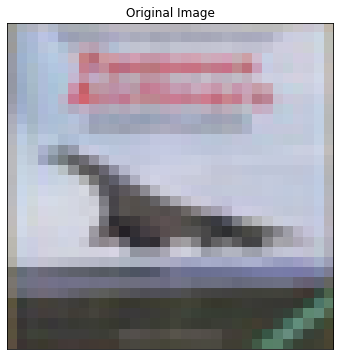

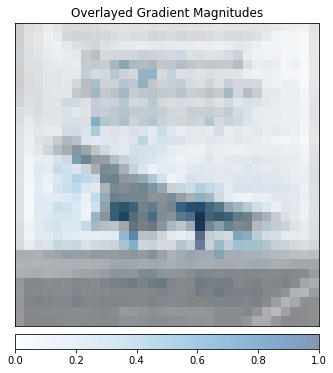

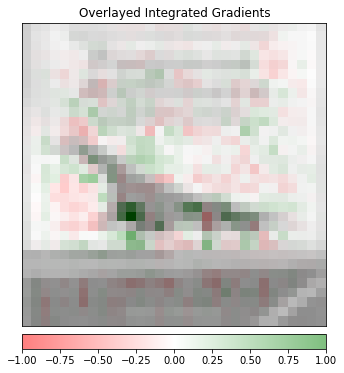

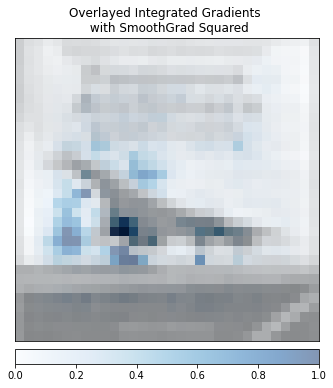

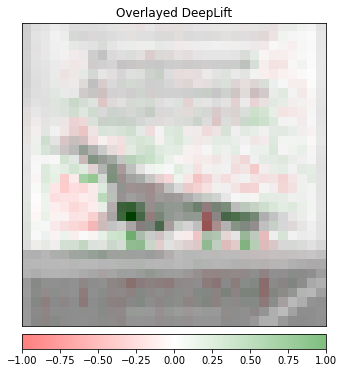

In [16]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")

